# Section 5

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics='F', beta=beta, eps=1e-10)

## Singular values

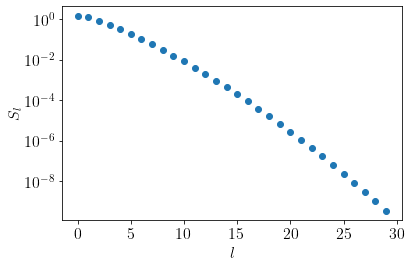

In [4]:
plt.semilogy(basis.s, marker='o', ls='')
plt.xlabel(r'$l$')
plt.ylabel(r'$S_l$')
plt.tight_layout()
plt.savefig('ir_basis_svals.pdf', transparent=True)

## $U_l(\tau)$ and $V_l(\omega)$

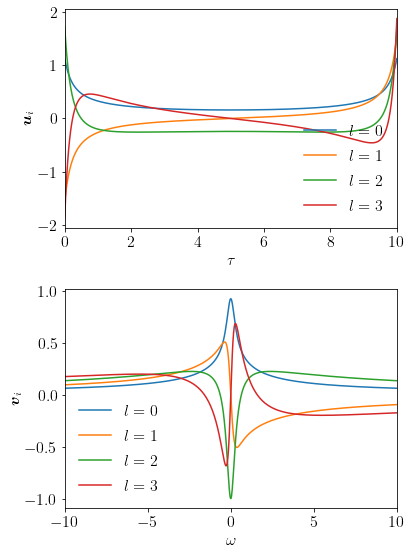

In [5]:
fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
axes = [ax1, ax2]

taus = np.linspace(0, beta, 1000)
omegas = np.linspace(-wmax, wmax, 1000)

for l in range(4):
    ax1.plot(taus, basis.u[l](taus), label=f'$l={l}$')
    ax2.plot(omegas, basis.v[l](omegas), label=f'$l={l}$')

ax1.set_xlabel(r'$\tau$')
ax2.set_xlabel(r'$\omega$')
ax1.set_ylabel(r'$\boldsymbol{u}_i$')
ax2.set_ylabel(r'$\boldsymbol{v}_i$')
ax1.set_xlim([0,beta])
ax2.set_xlim([-wmax, wmax])

ax1.legend(loc='best', frameon=False)
ax2.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig('ir_basis_functions.pdf', transparent=True)